## What changed?

This notebook uses the same method as `teeth - 3` to build the ensemble, but does so in a more academically rigorous manner. In the previous notebook, ALL images were used to train the data. In this notebook, a section of the images are quarantined so that the test data is truly never experienced until after the model is build.

In [1]:
# Check if CUDA

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA not detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 2060
GPU memory: 6.0 GB


In [2]:
# Academically Rigorous Multi-Architecture Ensemble Training Script

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

AVAILABLE_ARCHITECTURES = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'mobilenetv3_large_100']
AUGMENTATION_TARGET = 1000
NUM_FOLDS = 5
IMAGE_SIZE = (224, 448)

plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max(AUGMENTATION_TARGET, max_count)
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class MultiArchEnsembleTrainer:
    def __init__(self, num_classes, save_dir=None):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if save_dir is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.save_dir = f"academic_ensemble_{timestamp}"
        else:
            self.save_dir = save_dir
        
        os.makedirs(self.save_dir, exist_ok=True)
        print(f"Results will be saved to: {self.save_dir}")
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
        
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    def create_model(self, architecture):
        model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        
        if 'resnet' in architecture:
            frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
            for name, param in model.named_parameters():
                for frozen_layer in frozen_layers:
                    if name.startswith(frozen_layer):
                        param.requires_grad = False
                        break
        elif 'efficientnet' in architecture:
            for name, param in model.named_parameters():
                if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                    param.requires_grad = False
        elif 'mobilenet' in architecture:
            for name, param in model.named_parameters():
                if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                    param.requires_grad = False
        
        if hasattr(model, 'fc'):
            in_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, self.num_classes)
            )
        elif hasattr(model, 'classifier'):
            if hasattr(model.classifier, 'in_features'):
                in_features = model.classifier.in_features
                model.classifier = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
        
        return model.to(self.device)
    
    def train_single_model(self, train_loader, val_loader, architecture):
        model = self.create_model(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name or 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
                
                if batch_idx % 10 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(val_loader):
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
                    
                    if batch_idx % 5 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
            
            if epoch % 10 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history, architecture
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        best_model = None
        best_acc = 0.0
        best_history = None
        best_arch = None
        
        for arch in AVAILABLE_ARCHITECTURES:
            try:
                print(f"  Testing {arch}...")
                model, val_acc, history, architecture = self.train_single_model(train_loader, val_loader, arch)
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    best_history = history
                    best_arch = architecture
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"  Failed to train {arch}: {e}")
                continue
        
        return best_model, best_acc, best_history, best_arch
    
    def save_fold_immediately(self, model, fold_num, architecture, cv_score, label_mapping, history):
        model_path = os.path.join(self.save_dir, f"{architecture}_fold_{fold_num}_{cv_score:.1f}pct.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': architecture,
            'fold': fold_num,
            'cv_score': cv_score,
            'num_classes': self.num_classes,
            'label_mapping': label_mapping,
            'input_size': IMAGE_SIZE,
            'training_history': history
        }, model_path)
        
        print(f"  Saved fold {fold_num} to: {model_path}")
        return model_path
    
    def train_ensemble_academic(self, X_train, y_train, label_mapping):
        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
        fold_splits = list(skf.split(X_train, y_train))
        
        with open(os.path.join(self.save_dir, "label_mapping.json"), 'w') as f:
            json.dump(label_mapping, f, indent=2)
        
        with open(os.path.join(self.save_dir, "fold_splits.pkl"), 'wb') as f:
            pickle.dump(fold_splits, f)
        
        trained_models = []
        cv_scores = []
        training_histories = []
        architectures_used = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
            fold_num = fold_idx + 1
            print(f"Training Fold {fold_num}/{NUM_FOLDS}")
            
            X_train_fold = X_train[train_idx]
            y_train_fold = y_train[train_idx]
            X_val_fold = X_train[val_idx]
            y_val_fold = y_train[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            batch_size = 16 if torch.cuda.is_available() else 8
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            model, val_acc, history, best_arch = self.train_single_fold(train_loader, val_loader, fold_num)
            
            if model is not None:
                self.save_fold_immediately(model, fold_num, best_arch, val_acc, label_mapping, history)
                
                trained_models.append(model)
                cv_scores.append(val_acc)
                training_histories.append(history)
                architectures_used.append(best_arch)
                print(f"Fold {fold_num}/{NUM_FOLDS} completed: {val_acc:.1f}% with {best_arch}")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return trained_models, cv_scores, training_histories, architectures_used
    
    def evaluate_ensemble(self, models, cv_scores, test_loader):
        scores_array = np.array(cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        for model in models:
            model.eval()
        
        test_correct = 0
        test_total = 0
        all_ensemble_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                ensemble_outputs = torch.zeros(images.size(0), self.num_classes).to(self.device)
                
                for model, weight in zip(models, weights):
                    outputs1 = model(images)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    avg_outputs = (outputs1 + outputs2) / 2
                    
                    ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
                
                _, predicted = torch.max(ensemble_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                all_ensemble_probs.extend(ensemble_outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        ensemble_acc = 100 * test_correct / test_total
        
        return ensemble_acc, np.array(all_ensemble_probs), np.array(all_labels)

def save_final_ensemble(trainer, models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used):
    ensemble_path = os.path.join(trainer.save_dir, "academic_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': IMAGE_SIZE
    }, ensemble_path)
    
    with open(os.path.join(trainer.save_dir, "training_histories.pkl"), 'wb') as f:
        pickle.dump(training_histories, f)
    
    metadata = {
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'architectures_used': architectures_used,
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': f'{IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}',
        'augmentation_target': AUGMENTATION_TARGET,
        'completed': True,
        'academic_split': True
    }
    
    with open(os.path.join(trainer.save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Final ensemble saved to: {ensemble_path}")
    return trainer.save_dir

def plot_training_curves(training_histories, architectures_used, save_dir):
    Path(os.path.join(save_dir, "training_plots")).mkdir(exist_ok=True)
    
    fig, axes = plt.subplots(1, NUM_FOLDS, figsize=(4*NUM_FOLDS, 4))
    if NUM_FOLDS == 1:
        axes = [axes]
    
    for fold, (history, arch) in enumerate(zip(training_histories, architectures_used)):
        ax = axes[fold]
        epochs = range(1, len(history['train_accs']) + 1)
        
        ax.plot(epochs, history['train_accs'], 'b-', label='Training', linewidth=2, alpha=0.8)
        ax.plot(epochs, history['val_accs'], 'r-', label='Validation', linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Fold {fold + 1} ({arch})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plots", "training_curves.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    fig, axes = plt.subplots(1, NUM_FOLDS, figsize=(4*NUM_FOLDS, 4))
    if NUM_FOLDS == 1:
        axes = [axes]
    
    for fold, (history, arch) in enumerate(zip(training_histories, architectures_used)):
        ax = axes[fold]
        epochs = range(1, len(history['train_losses']) + 1)
        
        ax.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2, alpha=0.8)
        ax.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Fold {fold + 1} Loss ({arch})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plots", "loss_curves.png"), dpi=300, bbox_inches='tight')
    plt.close()

def main():
    print("Academically Rigorous Multi-Architecture Ensemble Training")
    print("=" * 80)
    print(f"Available architectures: {AVAILABLE_ARCHITECTURES}")
    print(f"Number of folds: {NUM_FOLDS}")
    print(f"Image size: {IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}")
    print(f"Augmentation target: {AUGMENTATION_TARGET} samples per class")
    
    start_time = time.time()
    
    try:
        print("Loading data...")
        images, ages = load_original_data()
        
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        y_indices = np.array([label_mapping[age] for age in ages])
        
        print(f"Total images: {len(images)}")
        print(f"Age distribution: {dict(Counter(ages))}")
        
        print("\n--- ACADEMIC TRAIN/TEST SPLIT ---")
        X_train_all, X_test_final, y_train_all, y_test_final = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        print(f"Training data: {len(X_train_all)} images")
        print(f"Test data: {len(X_test_final)} images")
        print("Test set will NOT be used until final evaluation")
        
        trainer = MultiArchEnsembleTrainer(num_classes=len(unique_ages))
        
        print("\n--- CROSS-VALIDATION ON TRAINING DATA ONLY ---")
        models, cv_scores, training_histories, architectures_used = trainer.train_ensemble_academic(
            X_train_all, y_train_all, label_mapping
        )
        
        print("\n--- FINAL EVALUATION ON HELD-OUT TEST SET ---")
        test_dataset = OptimizedDataset(X_test_final, y_test_final, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
        
        print("Saving final ensemble...")
        save_dir = save_final_ensemble(trainer, models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used)
        
        print("Generating training curves...")
        plot_training_curves(training_histories, architectures_used, save_dir)
        
        elapsed = (time.time() - start_time) / 60
        
        print("\n=== ACADEMIC RESULTS ===")
        print("Cross-Validation Results (Training Data Only):")
        for i, (score, arch) in enumerate(zip(cv_scores, architectures_used)):
            print(f"Fold {i+1}: {score:.1f}% ({arch})")
        print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"\nFinal Test Accuracy (Held-Out Data): {ensemble_acc:.1f}%")
        print(f"Training Time: {elapsed:.1f} minutes")
        print(f"All results saved to: {save_dir}")
        
        print("\n=== OVERFITTING ANALYSIS ===")
        print("Check training_plots/ for loss curves to verify no overfitting")
        
        return {
            'models': models,
            'cv_scores': cv_scores,
            'test_accuracy': ensemble_acc,
            'architectures_used': architectures_used,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Academically Rigorous Multi-Architecture Ensemble Training
Available architectures: ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'mobilenetv3_large_100']
Number of folds: 5
Image size: 448x224
Augmentation target: 1000 samples per class
Loading data...
Total images: 243
Age distribution: {0.5: 39, 2.5: 33, 3.5: 29, 1.5: 62, 4.5: 20, 5.5: 60}

--- ACADEMIC TRAIN/TEST SPLIT ---
Training data: 194 images
Test data: 49 images
Test set will NOT be used until final evaluation
Results will be saved to: academic_ensemble_20250721_081845
Using device: cuda
GPU: NVIDIA GeForce RTX 2060
GPU Memory: 6.0 GB

--- CROSS-VALIDATION ON TRAINING DATA ONLY ---
Training Fold 1/5
  Testing resnet18...
  Testing resnet34...
  Testing resnet50...
  Testing efficientnet_b0...
  Testing efficientnet_b1...
  Testing efficientnet_b2...
  Testing mobilenetv3_large_100...
  Saved fold 1 to: academic_ensemble_20250721_081845\efficientnet_b2_fold_1_92.3pct.pth
Fold 1/

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
import json
import pickle
from pathlib import Path
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    precision_score, recall_score, accuracy_score,
    precision_recall_curve, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

class ComprehensiveEvaluator:
    def __init__(self, ensemble_path, test_data_path=None, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.ensemble_path = ensemble_path
        self.test_data_path = test_data_path
        
        # Load ensemble
        self.ensemble_data = torch.load(ensemble_path, map_location=self.device)
        self.models = self._load_ensemble_models()
        self.label_mapping = self.ensemble_data['label_mapping']
        self.cv_scores = self.ensemble_data['cv_scores']
        self.architectures = self.ensemble_data['architectures_used']
        
        # Create output directory
        self.output_dir = Path("evaluation_results")
        self.output_dir.mkdir(exist_ok=True)
        
        print(f"Loaded ensemble with {len(self.models)} models")
        print(f"Architectures: {self.architectures}")
        print(f"CV Scores: {[f'{score:.1f}%' for score in self.cv_scores]}")
    
    def _load_ensemble_models(self):
        models = []
        state_dicts = self.ensemble_data['model_state_dicts']
        architectures = self.ensemble_data['architectures_used']
        num_classes = self.ensemble_data['num_classes']
        
        for state_dict, arch in zip(state_dicts, architectures):
            model = timm.create_model(arch, pretrained=False, num_classes=num_classes)
            
            # Recreate the same classifier structure used during training
            if hasattr(model, 'fc'):
                in_features = model.fc.in_features
                model.fc = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, num_classes)
                )
            elif hasattr(model, 'classifier'):
                if hasattr(model.classifier, 'in_features'):
                    in_features = model.classifier.in_features
                    model.classifier = nn.Sequential(
                        nn.Dropout(0.3),
                        nn.Linear(in_features, num_classes)
                    )
                else:
                    in_features = model.classifier[-1].in_features
                    model.classifier[-1] = nn.Sequential(
                        nn.Dropout(0.3),
                        nn.Linear(in_features, num_classes)
                    )
            
            model.load_state_dict(state_dict)
            model.to(self.device)
            model.eval()
            models.append(model)
        
        return models
    
    def load_test_data(self, data_path=None):
        """Load test data - modify this based on your data format"""
        if data_path:
            # Load from specific path
            pass
        else:
            # Load the original data and get test split
            fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
            image_paths = glob.glob(fpath)
            
            images = []
            ages = []
            image_names = []
            
            for img_path in image_paths:
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        continue
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img, (448, 224))  # W, H format for cv2
                    
                    filename = os.path.basename(img_path)
                    filename_no_ext = os.path.splitext(filename)[0]
                    parts = filename_no_ext.split('_')
                    
                    if len(parts) < 3:
                        continue
                    
                    bbb_part = parts[1]
                    if 'p' not in bbb_part:
                        continue
                    
                    value_str = bbb_part.replace('p', '.')
                    age_value = float(value_str)
                    age_value = 5.5 if age_value >= 5.5 else age_value
                    
                    images.append(img_resized)
                    ages.append(age_value)
                    image_names.append(filename)
                    
                except Exception as e:
                    continue
            
            # Convert to test set (same split as training)
            from sklearn.model_selection import train_test_split
            unique_ages = sorted(list(set(ages)))
            age_to_idx = {age: i for i, age in enumerate(unique_ages)}
            y_indices = [age_to_idx[age] for age in ages]
            
            _, X_test, _, y_test, _, names_test = train_test_split(
                images, y_indices, image_names, test_size=0.2, random_state=42, stratify=y_indices
            )
            
            self.X_test = np.array(X_test)
            self.y_test = np.array(y_test)
            self.test_names = names_test
            self.class_names = [str(age) for age in unique_ages]
            
            print(f"Loaded {len(self.X_test)} test images")
            print(f"Classes: {self.class_names}")
    
    def preprocess_image_for_model(self, image):
        """Preprocess single image for model input"""
        if image.max() > 1.0:
            image = image / 255.0
        
        # Convert to tensor and normalize
        if len(image.shape) == 3:
            image = torch.FloatTensor(image).permute(2, 0, 1)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)
    
    def get_ensemble_predictions(self, return_probs=True):
        """Get ensemble predictions for all test data"""
        all_probs = []
        all_preds = []
        
        # Calculate weights based on CV scores
        scores_array = np.array(self.cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        print("Computing ensemble predictions...")
        
        for i, image in enumerate(self.X_test):
            if i % 50 == 0:
                print(f"Processing image {i+1}/{len(self.X_test)}")
            
            # Preprocess image
            img_tensor = self.preprocess_image_for_model(image)
            
            # Get predictions from each model
            ensemble_output = torch.zeros(1, len(self.class_names)).to(self.device)
            
            with torch.no_grad():
                for model, weight in zip(self.models, weights):
                    # Original prediction
                    output1 = model(img_tensor)
                    # Flipped prediction (TTA)
                    flipped = torch.flip(img_tensor, [3])
                    output2 = model(flipped)
                    # Average and weight
                    avg_output = (output1 + output2) / 2
                    ensemble_output += weight * F.softmax(avg_output, dim=1)
            
            probs = ensemble_output.cpu().numpy()[0]
            pred = np.argmax(probs)
            
            all_probs.append(probs)
            all_preds.append(pred)
        
        self.y_pred = np.array(all_preds)
        self.y_probs = np.array(all_probs)
        
        print("Ensemble predictions complete!")
        return self.y_pred, self.y_probs if return_probs else self.y_pred
    
    def generate_confusion_matrix(self):
        """Generate and save confusion matrix"""
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Raw counts
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax1)
        ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Predicted Age', fontsize=12)
        ax1.set_ylabel('True Age', fontsize=12)
        
        # Percentages
        sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax2)
        ax2.set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Predicted Age', fontsize=12)
        ax2.set_ylabel('True Age', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Confusion matrices saved!")
    
    def generate_classification_metrics(self):
        """Generate comprehensive classification metrics"""
        # Calculate metrics
        accuracy = accuracy_score(self.y_test, self.y_pred)
        
        # Per-class metrics
        f1_macro = f1_score(self.y_test, self.y_pred, average='macro')
        f1_weighted = f1_score(self.y_test, self.y_pred, average='weighted')
        f1_per_class = f1_score(self.y_test, self.y_pred, average=None)
        
        precision_macro = precision_score(self.y_test, self.y_pred, average='macro')
        precision_per_class = precision_score(self.y_test, self.y_pred, average=None)
        
        recall_macro = recall_score(self.y_test, self.y_pred, average='macro')
        recall_per_class = recall_score(self.y_test, self.y_pred, average=None)
        
        # Create metrics DataFrame
        metrics_df = pd.DataFrame({
            'Class': self.class_names,
            'F1-Score': f1_per_class,
            'Precision': precision_per_class,
            'Recall': recall_per_class
        })
        
        # Create bar plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # F1 Scores
        bars1 = axes[0,0].bar(self.class_names, f1_per_class, color='skyblue', alpha=0.8)
        axes[0,0].axhline(y=f1_macro, color='red', linestyle='--', label=f'Macro Avg: {f1_macro:.3f}')
        axes[0,0].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
        axes[0,0].set_ylabel('F1-Score', fontsize=12)
        axes[0,0].set_ylim(0, 1)
        axes[0,0].legend()
        # Add value labels on bars
        for bar, val in zip(bars1, f1_per_class):
            axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Precision
        bars2 = axes[0,1].bar(self.class_names, precision_per_class, color='lightgreen', alpha=0.8)
        axes[0,1].axhline(y=precision_macro, color='red', linestyle='--', label=f'Macro Avg: {precision_macro:.3f}')
        axes[0,1].set_title('Precision per Class', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('Precision', fontsize=12)
        axes[0,1].set_ylim(0, 1)
        axes[0,1].legend()
        for bar, val in zip(bars2, precision_per_class):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Recall
        bars3 = axes[1,0].bar(self.class_names, recall_per_class, color='lightcoral', alpha=0.8)
        axes[1,0].axhline(y=recall_macro, color='red', linestyle='--', label=f'Macro Avg: {recall_macro:.3f}')
        axes[1,0].set_title('Recall per Class', fontsize=14, fontweight='bold')
        axes[1,0].set_ylabel('Recall', fontsize=12)
        axes[1,0].set_xlabel('Age Class', fontsize=12)
        axes[1,0].set_ylim(0, 1)
        axes[1,0].legend()
        for bar, val in zip(bars3, recall_per_class):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Overall metrics summary
        axes[1,1].axis('off')
        summary_text = f"""
        Overall Performance Summary:
        
        Accuracy: {accuracy:.3f}
        
        F1-Score (Macro): {f1_macro:.3f}
        F1-Score (Weighted): {f1_weighted:.3f}
        
        Precision (Macro): {precision_macro:.3f}
        Recall (Macro): {recall_macro:.3f}
        
        Best F1 Class: {self.class_names[np.argmax(f1_per_class)]} ({f1_per_class.max():.3f})
        Worst F1 Class: {self.class_names[np.argmin(f1_per_class)]} ({f1_per_class.min():.3f})
        """
        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                      fontsize=12, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'classification_metrics.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save metrics to CSV
        metrics_df.to_csv(self.output_dir / 'per_class_metrics.csv', index=False)
        
        print("Classification metrics saved!")
        return metrics_df
    
    def generate_class_distribution_plots(self):
        """Generate age class distribution plots"""
        # Count distributions
        true_counts = Counter(self.y_test)
        pred_counts = Counter(self.y_pred)
        
        # Convert to lists for plotting
        true_dist = [true_counts.get(i, 0) for i in range(len(self.class_names))]
        pred_dist = [pred_counts.get(i, 0) for i in range(len(self.class_names))]
        
        # Create comparison plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        x = np.arange(len(self.class_names))
        width = 0.35
        
        # Side by side bars
        bars1 = ax1.bar(x - width/2, true_dist, width, label='True Distribution', 
                       color='steelblue', alpha=0.8)
        bars2 = ax1.bar(x + width/2, pred_dist, width, label='Predicted Distribution', 
                       color='lightcoral', alpha=0.8)
        
        ax1.set_xlabel('Age Class', fontsize=12)
        ax1.set_ylabel('Number of Samples', fontsize=12)
        ax1.set_title('True vs Predicted Class Distributions', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(self.class_names)
        ax1.legend()
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        # Pie chart for true distribution
        ax2.pie(true_dist, labels=self.class_names, autopct='%1.1f%%', startangle=90)
        ax2.set_title('True Age Distribution', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'class_distributions.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Class distribution plots saved!")
    
    def generate_grad_cam_heatmaps(self, num_samples=9):
        """Generate Grad-CAM attention heatmaps for sample images (original + heatmap overlay)"""
        
        class GradCAM:
            def __init__(self, model):
                self.model = model
                self.target_layer = None
                self.gradients = None
                self.activations = None
                
                # Find the last convolutional layer
                for name, module in self.model.named_modules():
                    if isinstance(module, nn.Conv2d):
                        self.target_layer = module
                
                self.target_layer.register_forward_hook(self.save_activation)
                self.target_layer.register_backward_hook(self.save_gradient)
            
            def save_activation(self, module, input, output):
                self.activations = output
            
            def save_gradient(self, module, grad_input, grad_output):
                self.gradients = grad_output[0]
            
            def generate_cam(self, input_tensor, class_idx):
                # Forward pass
                output = self.model(input_tensor)
                
                # Backward pass
                self.model.zero_grad()
                output[0, class_idx].backward(retain_graph=True)
                
                # Generate CAM
                gradients = self.gradients.cpu().data.numpy()[0]
                activations = self.activations.cpu().data.numpy()[0]
                
                weights = np.mean(gradients, axis=(1, 2))
                cam = np.zeros(activations.shape[1:], dtype=np.float32)
                
                for i, w in enumerate(weights):
                    cam += w * activations[i]
                
                cam = np.maximum(cam, 0)
                cam = cam / cam.max() if cam.max() > 0 else cam
                cam = cv2.resize(cam, (448, 224))
                
                return cam
        
        # Select diverse samples (one from each class if possible)
        selected_indices = []
        for class_idx in range(len(self.class_names)):
            class_indices = np.where(self.y_test == class_idx)[0]
            if len(class_indices) > 0:
                # Select the sample with highest confidence for this class
                class_probs = self.y_probs[class_indices, class_idx]
                best_idx = class_indices[np.argmax(class_probs)]
                selected_indices.append(best_idx)
        
        # Fill up to num_samples with random samples if needed
        while len(selected_indices) < num_samples and len(selected_indices) < len(self.X_test):
            remaining_indices = set(range(len(self.X_test))) - set(selected_indices)
            if remaining_indices:
                selected_indices.append(np.random.choice(list(remaining_indices)))
        
        selected_indices = selected_indices[:num_samples]
        
        # Create the visualization
        fig = plt.figure(figsize=(12, 4 * len(selected_indices)))
        
        for i, idx in enumerate(selected_indices):
            image = self.X_test[idx]
            true_class = self.y_test[idx]
            pred_class = self.y_pred[idx]
            probs = self.y_probs[idx]
            
            # Get Grad-CAM from the best model (highest CV score)
            best_model_idx = np.argmax(self.cv_scores)
            best_model = self.models[best_model_idx]
            
            grad_cam = GradCAM(best_model)
            img_tensor = self.preprocess_image_for_model(image)
            
            # Generate heatmap for predicted class
            heatmap = grad_cam.generate_cam(img_tensor, pred_class)
            
            # Create subplot layout: original | heatmap (tight spacing)
            gs = plt.GridSpec(1, 2, figure=fig, width_ratios=[1, 1],
                            top=1-i/len(selected_indices), bottom=1-(i+1)/len(selected_indices),
                            left=0.02, right=0.98, wspace=0.02, hspace=0.02)
            
            # Original image
            ax1 = fig.add_subplot(gs[0])
            ax1.imshow(image)
            ax1.set_title(f'Original Image\nTrue: {self.class_names[true_class]} | Pred: {self.class_names[pred_class]}', 
                         fontsize=12, fontweight='bold')
            ax1.axis('off')
            
            # Heatmap overlay
            ax2 = fig.add_subplot(gs[1])
            ax2.imshow(image)
            heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]
            ax2.imshow(heatmap_colored, alpha=0.6)
            ax2.set_title(f'Attention Heatmap\n(Focus: {self.class_names[pred_class]})', 
                         fontsize=12, fontweight='bold')
            ax2.axis('off')
        
        plt.savefig(self.output_dir / 'attention_heatmaps.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Attention heatmaps saved!")
    
    def generate_ensemble_analysis(self):
        """Analyze ensemble component performance"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # CV Scores comparison
        bars1 = axes[0,0].bar(range(len(self.architectures)), self.cv_scores, 
                             color=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'purple'][:len(self.architectures)])
        axes[0,0].set_title('Cross-Validation Scores by Architecture', fontsize=14, fontweight='bold')
        axes[0,0].set_ylabel('CV Score (%)', fontsize=12)
        axes[0,0].set_xticks(range(len(self.architectures)))
        axes[0,0].set_xticklabels(self.architectures, rotation=45, ha='right')
        
        # Add value labels
        for bar, score in zip(bars1, self.cv_scores):
            axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                          f'{score:.1f}%', ha='center', va='bottom', fontsize=10)
        
        # Ensemble weights
        scores_array = np.array(self.cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        bars2 = axes[0,1].bar(range(len(self.architectures)), weights, 
                             color=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'purple'][:len(self.architectures)])
        axes[0,1].set_title('Ensemble Weights', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('Weight', fontsize=12)
        axes[0,1].set_xticks(range(len(self.architectures)))
        axes[0,1].set_xticklabels(self.architectures, rotation=45, ha='right')
        
        # Add value labels
        for bar, weight in zip(bars2, weights):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{weight:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Model architecture distribution
        arch_counts = Counter(self.architectures)
        axes[1,0].pie(arch_counts.values(), labels=arch_counts.keys(), autopct='%1.0f%%', startangle=90)
        axes[1,0].set_title('Architecture Distribution in Ensemble', fontsize=14, fontweight='bold')
        
        # Performance summary
        axes[1,1].axis('off')
        ensemble_accuracy = accuracy_score(self.y_test, self.y_pred)
        summary_text = f"""
        Ensemble Performance Summary:
        
        Number of Models: {len(self.models)}
        Architectures Used: {len(set(self.architectures))}
        
        Best Individual CV: {max(self.cv_scores):.1f}%
        Worst Individual CV: {min(self.cv_scores):.1f}%
        Mean CV Score: {np.mean(self.cv_scores):.1f}%
        
        Final Test Accuracy: {ensemble_accuracy:.1f}%
        
        Ensemble Improvement: {ensemble_accuracy*100 - np.mean(self.cv_scores):.1f} percentage points
        """
        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                      fontsize=12, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'ensemble_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Ensemble analysis saved!")
    
    def generate_error_analysis(self):
        """Analyze prediction errors"""
        # Find misclassified samples
        errors = self.y_test != self.y_pred
        error_indices = np.where(errors)[0]
        
        if len(error_indices) == 0:
            print("No errors found!")
            return
        
        # Error types
        error_types = []
        for idx in error_indices:
            true_age = float(self.class_names[self.y_test[idx]])
            pred_age = float(self.class_names[self.y_pred[idx]])
            error_types.append(abs(true_age - pred_age))
        
        # Create error analysis plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Error magnitude distribution
        axes[0,0].hist(error_types, bins=10, color='lightcoral', alpha=0.7, edgecolor='black')
        axes[0,0].set_title('Error Magnitude Distribution', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('Age Difference (|True - Predicted|)', fontsize=12)
        axes[0,0].set_ylabel('Frequency', fontsize=12)
        
        # Error by true class
        error_by_class = {class_name: [] for class_name in self.class_names}
        for idx in error_indices:
            true_class_name = self.class_names[self.y_test[idx]]
            pred_class_name = self.class_names[self.y_pred[idx]]
            error_by_class[true_class_name].append(pred_class_name)
        
        error_rates = [len(errors) / list(self.y_test).count(i) * 100 
                      for i, errors in enumerate([error_by_class[name] for name in self.class_names])]
        
        bars = axes[0,1].bar(self.class_names, error_rates, color='orange', alpha=0.7)
        axes[0,1].set_title('Error Rate by True Class', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('Error Rate (%)', fontsize=12)
        axes[0,1].set_xlabel('True Age Class', fontsize=12)
        
        # Add value labels
        for bar, rate in zip(bars, error_rates):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                          f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)
        
        # Confidence vs Accuracy
        confidences = np.max(self.y_probs, axis=1)
        correct = self.y_test == self.y_pred
        
        axes[1,0].scatter(confidences[correct], [1]*sum(correct), alpha=0.5, color='green', label='Correct')
        axes[1,0].scatter(confidences[~correct], [0]*sum(~correct), alpha=0.5, color='red', label='Incorrect')
        axes[1,0].set_title('Prediction Confidence vs Accuracy', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Max Probability', fontsize=12)
        axes[1,0].set_ylabel('Correct (1) / Incorrect (0)', fontsize=12)
        axes[1,0].legend()
        
        # Summary statistics
        axes[1,1].axis('off')
        total_errors = len(error_indices)
        avg_error = np.mean(error_types) if error_types else 0
        max_error = max(error_types) if error_types else 0
        avg_confidence_correct = np.mean(confidences[correct]) if sum(correct) > 0 else 0
        avg_confidence_wrong = np.mean(confidences[~correct]) if sum(~correct) > 0 else 0
        
        summary_text = f"""
        Error Analysis Summary:
        
        Total Errors: {total_errors} / {len(self.y_test)} ({total_errors/len(self.y_test)*100:.1f}%)
        
        Average Error Magnitude: {avg_error:.2f} years
        Maximum Error: {max_error:.1f} years
        
        Avg Confidence (Correct): {avg_confidence_correct:.3f}
        Avg Confidence (Wrong): {avg_confidence_wrong:.3f}
        
        Most Confused Classes:
        {self.class_names[np.argmax(error_rates)]} ({max(error_rates):.1f}% error rate)
        """
        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                      fontsize=12, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="mistyrose", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'error_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Error analysis saved!")
    
    def generate_comprehensive_report(self):
        """Generate a comprehensive evaluation report"""
        print("=" * 60)
        print("COMPREHENSIVE ENSEMBLE MODEL EVALUATION")
        print("=" * 60)
        
        # Load test data
        print("\n1. Loading test data...")
        self.load_test_data()
        
        # Get predictions
        print("\n2. Computing ensemble predictions...")
        self.get_ensemble_predictions()
        
        # Generate all visualizations
        print("\n3. Generating confusion matrices...")
        self.generate_confusion_matrix()
        
        print("\n4. Computing classification metrics...")
        metrics_df = self.generate_classification_metrics()
        
        print("\n5. Creating class distribution plots...")
        self.generate_class_distribution_plots()
        
        print("\n6. Generating attention heatmaps...")
        self.generate_grad_cam_heatmaps()
        
        print("\n7. Analyzing ensemble performance...")
        self.generate_ensemble_analysis()
        
        print("\n8. Performing error analysis...")
        self.generate_error_analysis()
        
        # Save final summary
        accuracy = accuracy_score(self.y_test, self.y_pred)
        f1_macro = f1_score(self.y_test, self.y_pred, average='macro')
        
        summary = {
            'test_accuracy': float(accuracy),
            'f1_macro': float(f1_macro),
            'cv_scores': self.cv_scores,
            'architectures': self.architectures,
            'num_test_samples': len(self.y_test),
            'num_classes': len(self.class_names),
            'class_names': self.class_names
        }
        
        with open(self.output_dir / 'evaluation_summary.json', 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\n{'='*60}")
        print("EVALUATION COMPLETE!")
        print(f"{'='*60}")
        print(f"Test Accuracy: {accuracy:.1%}")
        print(f"F1-Score (Macro): {f1_macro:.3f}")
        print(f"Results saved to: {self.output_dir}")
        print(f"{'='*60}")

# Usage example
if __name__ == "__main__":
    # Initialize evaluator
    ensemble_path = "./academic_ensemble_20250721_081845 (90.7 +- 2.6%)/academic_ensemble.pth"  # Update this path
    evaluator = ComprehensiveEvaluator(ensemble_path)
    
    # Generate comprehensive report
    evaluator.generate_comprehensive_report()

Loaded ensemble with 5 models
Architectures: ['efficientnet_b2', 'efficientnet_b0', 'efficientnet_b0', 'efficientnet_b2', 'efficientnet_b0']
CV Scores: ['92.3%', '87.2%', '94.9%', '89.7%', '89.5%']
COMPREHENSIVE ENSEMBLE MODEL EVALUATION

1. Loading test data...
Loaded 49 test images
Classes: ['0.5', '1.5', '2.5', '3.5', '4.5', '5.5']

2. Computing ensemble predictions...
Computing ensemble predictions...
Processing image 1/49
Ensemble predictions complete!

3. Generating confusion matrices...
Confusion matrices saved!

4. Computing classification metrics...
Classification metrics saved!

5. Creating class distribution plots...
Class distribution plots saved!

6. Generating attention heatmaps...
Attention heatmaps saved!

7. Analyzing ensemble performance...
Ensemble analysis saved!

8. Performing error analysis...
Error analysis saved!

EVALUATION COMPLETE!
Test Accuracy: 77.6%
F1-Score (Macro): 0.760
Results saved to: evaluation_results


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class OverfittingDiagnostic:
    def __init__(self, ensemble_path):
        self.ensemble_path = ensemble_path
        self.ensemble_data = torch.load(ensemble_path, map_location='cpu')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load original data
        self.load_all_data()
        
        # Create output directory
        self.output_dir = Path("diagnostic_results")
        self.output_dir.mkdir(exist_ok=True)
        
    def load_all_data(self):
        """Load all original data to check for issues"""
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        image_paths = glob.glob(fpath)
        
        images = []
        ages = []
        filenames = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                age_value = float(value_str)
                age_value = 5.5 if age_value >= 5.5 else age_value
                
                images.append(img_resized)
                ages.append(age_value)
                filenames.append(filename)
                
            except Exception as e:
                continue
        
        # Convert ages to indices
        unique_ages = sorted(list(set(ages)))
        self.age_to_idx = {age: i for i, age in enumerate(unique_ages)}
        y_indices = [self.age_to_idx[age] for age in ages]
        
        # Same split as used in training
        X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
            images, y_indices, filenames, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        self.X_train = np.array(X_train)
        self.X_test = np.array(X_test)
        self.y_train = np.array(y_train)
        self.y_test = np.array(y_test)
        self.names_train = names_train
        self.names_test = names_test
        self.class_names = [str(age) for age in unique_ages]
        
        print(f"Loaded {len(self.X_train)} training images, {len(self.X_test)} test images")
        print(f"Classes: {self.class_names}")
    
    def check_data_leakage(self):
        """Check for potential data leakage between train and test sets"""
        print("\n=== DATA LEAKAGE ANALYSIS ===")
        
        # Check for duplicate filenames (should be impossible but let's verify)
        train_set = set(self.names_train)
        test_set = set(self.names_test)
        overlap = train_set.intersection(test_set)
        
        print(f"Filename overlap between train/test: {len(overlap)}")
        if overlap:
            print(f"Overlapping files: {list(overlap)[:5]}...")
        
        # Check for very similar filenames (potential same patient)
        potential_leaks = []
        for test_name in self.names_test:
            test_base = test_name.split('_')[0] if '_' in test_name else test_name[:5]
            for train_name in self.names_train:
                train_base = train_name.split('_')[0] if '_' in train_name else train_name[:5]
                if test_base == train_base and test_name != train_name:
                    potential_leaks.append((test_name, train_name))
        
        print(f"Potential patient leaks (same base filename): {len(potential_leaks)}")
        if potential_leaks:
            print("Examples:")
            for i, (test, train) in enumerate(potential_leaks[:5]):
                print(f"  Test: {test} <-> Train: {train}")
        
        # Analyze filename patterns
        print(f"\nFilename pattern analysis:")
        print(f"Train filename examples: {self.names_train[:5]}")
        print(f"Test filename examples: {self.names_test[:5]}")
        
        return len(overlap), len(potential_leaks)
    
    def analyze_class_distributions(self):
        """Compare train vs test class distributions"""
        print("\n=== CLASS DISTRIBUTION ANALYSIS ===")
        
        train_dist = Counter(self.y_train)
        test_dist = Counter(self.y_test)
        
        # Create comparison
        comparison_data = []
        for i, class_name in enumerate(self.class_names):
            train_count = train_dist.get(i, 0)
            test_count = test_dist.get(i, 0)
            train_pct = train_count / len(self.y_train) * 100
            test_pct = test_count / len(self.y_test) * 100
            
            comparison_data.append({
                'Class': class_name,
                'Train_Count': train_count,
                'Test_Count': test_count,
                'Train_Pct': train_pct,
                'Test_Pct': test_pct,
                'Pct_Diff': abs(train_pct - test_pct)
            })
        
        df = pd.DataFrame(comparison_data)
        print(df)
        
        # Plot distributions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        x = np.arange(len(self.class_names))
        width = 0.35
        
        ax1.bar(x - width/2, [train_dist.get(i, 0) for i in range(len(self.class_names))], 
                width, label='Train', alpha=0.8)
        ax1.bar(x + width/2, [test_dist.get(i, 0) for i in range(len(self.class_names))], 
                width, label='Test', alpha=0.8)
        ax1.set_xlabel('Age Class')
        ax1.set_ylabel('Count')
        ax1.set_title('Train vs Test Distribution (Counts)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(self.class_names)
        ax1.legend()
        
        # Percentage differences
        pct_diffs = df['Pct_Diff'].values
        bars = ax2.bar(self.class_names, pct_diffs, color='red', alpha=0.7)
        ax2.set_xlabel('Age Class')
        ax2.set_ylabel('Percentage Point Difference')
        ax2.set_title('Train vs Test Distribution Differences')
        ax2.axhline(y=5, color='orange', linestyle='--', label='5% threshold')
        ax2.legend()
        
        for bar, diff in zip(bars, pct_diffs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{diff:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'distribution_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        max_diff = df['Pct_Diff'].max()
        print(f"Maximum distribution difference: {max_diff:.1f} percentage points")
        
        return df
    
    def test_individual_fold_performance(self):
        """Test each fold's performance on the test set individually"""
        print("\n=== INDIVIDUAL FOLD ANALYSIS ===")
        
        # We'll need to load the individual fold models
        ensemble_dir = Path(self.ensemble_path).parent
        fold_files = list(ensemble_dir.glob("*_fold_*.pth"))
        
        if not fold_files:
            print("No individual fold files found. Cannot analyze individual performance.")
            return
        
        individual_results = []
        
        print(f"Found {len(fold_files)} fold models")
        
        for fold_file in fold_files:
            try:
                fold_data = torch.load(fold_file, map_location='cpu')
                cv_score = fold_data['cv_score']
                architecture = fold_data['model_architecture']
                fold_num = fold_data['fold']
                
                # Load and test this individual model
                import timm
                import torch.nn as nn
                
                model = timm.create_model(architecture, pretrained=False, 
                                        num_classes=len(self.class_names))
                
                # Recreate classifier structure
                if hasattr(model, 'fc'):
                    in_features = model.fc.in_features
                    model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_features, len(self.class_names)))
                elif hasattr(model, 'classifier'):
                    if hasattr(model.classifier, 'in_features'):
                        in_features = model.classifier.in_features
                        model.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_features, len(self.class_names)))
                
                model.load_state_dict(fold_data['model_state_dict'])
                model.eval()
                
                # Test on test set
                test_accuracy = self.evaluate_single_model(model)
                
                individual_results.append({
                    'Fold': fold_num,
                    'Architecture': architecture,
                    'CV_Score': cv_score,
                    'Test_Accuracy': test_accuracy,
                    'Gap': cv_score - test_accuracy
                })
                
                print(f"Fold {fold_num} ({architecture}): CV={cv_score:.1f}%, Test={test_accuracy:.1f}%, Gap={cv_score-test_accuracy:.1f}%")
                
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
                continue
        
        if individual_results:
            df = pd.DataFrame(individual_results)
            
            # Plot individual gaps
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # CV vs Test scores
            folds = [f"Fold {r['Fold']}" for r in individual_results]
            cv_scores = [r['CV_Score'] for r in individual_results]
            test_scores = [r['Test_Accuracy'] for r in individual_results]
            
            x = np.arange(len(folds))
            width = 0.35
            
            ax1.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.8)
            ax1.bar(x + width/2, test_scores, width, label='Test Score', alpha=0.8)
            ax1.set_xlabel('Model Fold')
            ax1.set_ylabel('Accuracy (%)')
            ax1.set_title('CV vs Test Performance by Fold')
            ax1.set_xticks(x)
            ax1.set_xticklabels(folds, rotation=45)
            ax1.legend()
            
            # Performance gaps
            gaps = [r['Gap'] for r in individual_results]
            bars = ax2.bar(folds, gaps, color='red', alpha=0.7)
            ax2.set_xlabel('Model Fold')
            ax2.set_ylabel('Performance Gap (%)')
            ax2.set_title('CV - Test Performance Gap by Fold')
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax2.set_xticklabels(folds, rotation=45)
            
            for bar, gap in zip(bars, gaps):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        f'{gap:.1f}%', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.savefig(self.output_dir / 'individual_fold_analysis.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            avg_gap = np.mean(gaps)
            print(f"Average CV-Test gap across folds: {avg_gap:.1f}%")
            
            return df
        
        return None
    
    def evaluate_single_model(self, model):
        """Evaluate a single model on test set"""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for image in self.X_test:
                # Preprocess
                if image.max() > 1.0:
                    image = image / 255.0
                
                image_tensor = torch.FloatTensor(image).permute(2, 0, 1)
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                image_tensor = (image_tensor - mean) / std
                image_tensor = image_tensor.unsqueeze(0)
                
                outputs = model(image_tensor)
                predicted = torch.argmax(outputs, dim=1).item()
                
                correct += 1 if predicted == self.y_test[total] else 0
                total += 1
        
        return (correct / total) * 100
    
    def analyze_dataset_size_impact(self):
        """Analyze if small dataset size is causing the issue"""
        print("\n=== DATASET SIZE ANALYSIS ===")
        
        total_samples = len(self.X_train) + len(self.X_test)
        samples_per_class = total_samples / len(self.class_names)
        test_samples_per_class = len(self.X_test) / len(self.class_names)
        
        print(f"Total dataset size: {total_samples}")
        print(f"Average samples per class: {samples_per_class:.1f}")
        print(f"Test samples per class: {test_samples_per_class:.1f}")
        print(f"Test set size: {len(self.X_test)} ({len(self.X_test)/total_samples*100:.1f}% of total)")
        
        # Check class representation in test set
        min_test_class = min(Counter(self.y_test).values())
        max_test_class = max(Counter(self.y_test).values())
        
        print(f"Test set class range: {min_test_class} to {max_test_class} samples")
        
        if min_test_class < 10:
            print("⚠️  WARNING: Some classes have very few test samples (<10)")
        if test_samples_per_class < 20:
            print("⚠️  WARNING: Very small test set - high variance expected")
        
        return {
            'total_samples': total_samples,
            'test_size': len(self.X_test),
            'min_test_class': min_test_class,
            'max_test_class': max_test_class,
            'avg_test_per_class': test_samples_per_class
        }
    
    def generate_recommendations(self, leakage_info, distribution_df, size_info, individual_df=None):
        """Generate recommendations based on analysis"""
        print("\n" + "="*60)
        print("DIAGNOSTIC SUMMARY & RECOMMENDATIONS")
        print("="*60)
        
        issues_found = []
        recommendations = []
        
        # Check for data leakage
        if leakage_info[0] > 0:
            issues_found.append("Direct filename overlap between train/test")
            recommendations.append("🔥 CRITICAL: Remove overlapping files from train or test set")
        
        if leakage_info[1] > 0:
            issues_found.append(f"Potential patient leaks: {leakage_info[1]} cases")
            recommendations.append("⚠️  Check if same patients appear in both train/test")
        
        # Check distribution differences
        max_dist_diff = distribution_df['Pct_Diff'].max()
        if max_dist_diff > 10:
            issues_found.append(f"Large distribution differences: {max_dist_diff:.1f}%")
            recommendations.append("📊 Consider stratified sampling with more constraints")
        
        # Check dataset size
        if size_info['test_size'] < 100:
            issues_found.append("Very small test set")
            recommendations.append("📈 Consider larger dataset or repeated train/test splits")
        
        if size_info['min_test_class'] < 5:
            issues_found.append("Some classes have very few test samples")
            recommendations.append("⚖️  Use stratified sampling to ensure minimum samples per class")
        
        # Check individual model performance
        if individual_df is not None:
            avg_gap = individual_df['Gap'].mean()
            if avg_gap > 10:
                issues_found.append(f"Consistent overfitting across folds: {avg_gap:.1f}% avg gap")
                recommendations.append("🔧 Reduce model complexity or increase regularization")
                recommendations.append("🔧 Reduce aggressive data augmentation")
                recommendations.append("🔧 Add more diverse real data")
        
        # Print findings
        if issues_found:
            print("ISSUES FOUND:")
            for i, issue in enumerate(issues_found, 1):
                print(f"{i}. {issue}")
        else:
            print("No obvious issues detected in basic checks.")
        
        print(f"\nRECOMMENDATIONS:")
        if recommendations:
            for i, rec in enumerate(recommendations, 1):
                print(f"{i}. {rec}")
        else:
            print("1. 🔍 The 13% CV-Test gap suggests overfitting despite no obvious data issues")
            print("2. 🔧 Try reducing augmentation intensity")
            print("3. 🔧 Add more regularization (dropout, weight decay)")
            print("4. 📊 Consider k-fold evaluation on multiple random splits")
            print("5. 📈 Collect more diverse real data if possible")
        
        print("="*60)
    
    def run_comprehensive_diagnostic(self):
        """Run all diagnostic tests"""
        print("OVERFITTING DIAGNOSTIC ANALYSIS")
        print("="*50)
        
        # Run all analyses
        leakage_info = self.check_data_leakage()
        distribution_df = self.analyze_class_distributions()
        size_info = self.analyze_dataset_size_impact()
        individual_df = self.test_individual_fold_performance()
        
        # Generate recommendations
        self.generate_recommendations(leakage_info, distribution_df, size_info, individual_df)
        
        # Save summary
        summary = {
            'filename_overlap': leakage_info[0],
            'potential_patient_leaks': leakage_info[1],
            'max_distribution_difference': float(distribution_df['Pct_Diff'].max()),
            'test_set_size': size_info['test_size'],
            'min_test_class_size': size_info['min_test_class'],
            'individual_fold_gaps': individual_df['Gap'].tolist() if individual_df is not None else []
        }
        
        with open(self.output_dir / 'diagnostic_summary.json', 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\nDiagnostic results saved to: {self.output_dir}")

# Usage
if __name__ == "__main__":
    ensemble_path = "./(teeth) academic_ensemble_20250721_081845 (90.7 +- 2.6%)/academic_ensemble.pth"
    diagnostic = OverfittingDiagnostic(ensemble_path)
    diagnostic.run_comprehensive_diagnostic()

Loaded 194 training images, 49 test images
Classes: ['0.5', '1.5', '2.5', '3.5', '4.5', '5.5']
OVERFITTING DIAGNOSTIC ANALYSIS

=== DATA LEAKAGE ANALYSIS ===
Filename overlap between train/test: 0
Potential patient leaks (same base filename): 1760
Examples:
  Test: cpj_1p5_001.png <-> Train: cpj_1p5_000.png
  Test: cpj_1p5_001.png <-> Train: cpj_4p5_000.png
  Test: cpj_1p5_001.png <-> Train: cpj_7p5_000.png
  Test: cpj_1p5_001.png <-> Train: cpj_2p5_000.png
  Test: cpj_1p5_001.png <-> Train: cpj_0p5_000.png

Filename pattern analysis:
Train filename examples: ['vfl_6p5_004.png', 'vfl_1p5_011.png', 'qdma_3p5_012.png', 'vfl_1p5_000.png', 'cpj_1p5_000.png']
Test filename examples: ['cpj_1p5_001.png', 'jbn_1p5_001.png', 'vfl_1p5_025.png', 'jbn_1p5_006.png', 'nda_0p5_001.png']

=== CLASS DISTRIBUTION ANALYSIS ===
  Class  Train_Count  Test_Count  Train_Pct   Test_Pct  Pct_Diff
0   0.5           31           8  15.979381  16.326531  0.347149
1   1.5           50          12  25.773196  24.48

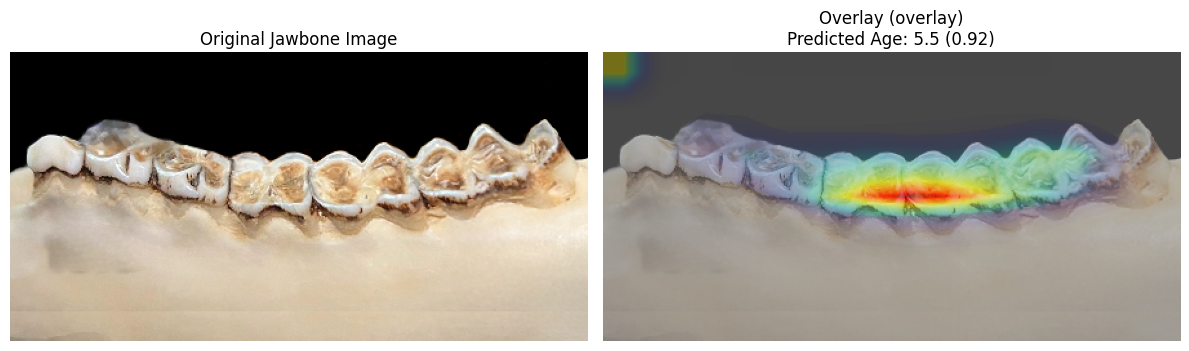

In [80]:
# Figuring out coloration for heatmap overlay

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import timm
from pathlib import Path

class JawboneModelRunner:
    def __init__(self, ensemble_path):
        self.ensemble_path = ensemble_path
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.models = []
        self.class_names = []
        self.load_ensemble()
        
    def load_ensemble(self):
        """Load the ensemble model"""
        ensemble_data = torch.load(self.ensemble_path, map_location=self.device)
        
        # Handle the specific ensemble format from your script
        if 'model_state_dicts' in ensemble_data:
            model_state_dicts = ensemble_data['model_state_dicts']
            architectures = ensemble_data['architectures_used']
            num_classes = ensemble_data['num_classes']
            label_mapping = ensemble_data.get('label_mapping', {})
            
            # Create class names from label mapping or use indices
            if label_mapping:
                sorted_labels = sorted(label_mapping.items(), key=lambda x: x[1])
                self.class_names = [label for label, idx in sorted_labels]
            else:
                self.class_names = [str(i) for i in range(num_classes)]
            
            # Load each model
            for i, (state_dict, architecture) in enumerate(zip(model_state_dicts, architectures)):
                try:
                    model = timm.create_model(architecture, pretrained=False, num_classes=num_classes)
                    
                    # Recreate classifier structure
                    if hasattr(model, 'fc'):
                        in_features = model.fc.in_features
                        model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_features, num_classes))
                    elif hasattr(model, 'classifier'):
                        if hasattr(model.classifier, 'in_features'):
                            in_features = model.classifier.in_features
                            model.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_features, num_classes))
                    
                    model.load_state_dict(state_dict)
                    model.to(self.device)
                    model.eval()
                    self.models.append(model)
                    
                except Exception as e:
                    continue
        
        if not self.models:
            raise ValueError("Failed to load any models from ensemble!")
    
    def preprocess_image(self, image_path):
        """Preprocess image for model input"""
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (448, 224))
        img_normalized = img_resized.astype(np.float32) / 255.0
        
        img_tensor = torch.FloatTensor(img_normalized).permute(2, 0, 1)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_tensor = (img_tensor - mean) / std
        img_tensor = img_tensor.unsqueeze(0).to(self.device)
        
        return img_resized, img_tensor
    
    def find_target_layer(self, model):
        """Find the best layer for GradCAM - target the last conv layer before classifier"""
        target_layer = None
        
        # Look for the last convolutional layer before global pooling/classifier
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                # Skip very small conv layers (like 1x1 convs in classifier)
                if module.kernel_size[0] > 1 or module.out_channels > 512:
                    target_layer = module
        
        # Fallback: look for specific layer names in common architectures
        if target_layer is None:
            layer_candidates = [
                'features', 'layer4', 'stages', 'blocks', 'conv_head', 
                'conv5', 'conv4', 'mixed_7', 'Mixed_7'
            ]
            
            for candidate in layer_candidates:
                for name, module in model.named_modules():
                    if candidate in name and isinstance(module, (nn.Conv2d, nn.Sequential)):
                        target_layer = module
                        break
                if target_layer:
                    break
        
        return target_layer
    
    def generate_gradcam_heatmap(self, model, input_tensor, target_class=None):
        """Generate focused GradCAM heatmap"""
        model.eval()
        
        # Find the right layer
        target_layer = self.find_target_layer(model)
        if target_layer is None:
            return self.generate_integrated_gradients_heatmap(model, input_tensor)
        
        # Storage for gradients and activations
        gradients = []
        activations = []
        
        def backward_hook(module, grad_input, grad_output):
            if grad_output[0] is not None:
                gradients.append(grad_output[0].detach())
        
        def forward_hook(module, input, output):
            activations.append(output.detach())
        
        # Register hooks
        hook1 = target_layer.register_backward_hook(backward_hook)
        hook2 = target_layer.register_forward_hook(forward_hook)
        
        try:
            # Forward pass
            input_tensor.requires_grad_(True)
            output = model(input_tensor)
            
            if target_class is None:
                target_class = torch.argmax(output, dim=1)
            
            # Backward pass
            model.zero_grad()
            output[0, target_class].backward(retain_graph=True)
            
            if gradients and activations:
                grads = gradients[0]  # Shape: [1, channels, h, w]
                acts = activations[0]  # Shape: [1, channels, h, w]
                
                # Compute importance weights (global average pooling of gradients)
                weights = torch.mean(grads, dim=(2, 3), keepdim=True)  # [1, channels, 1, 1]
                
                # Weighted combination of feature maps
                weighted_acts = weights * acts  # [1, channels, h, w]
                heatmap = torch.sum(weighted_acts, dim=1, keepdim=True)  # [1, 1, h, w]
                
                # Apply ReLU to remove negative influences
                heatmap = F.relu(heatmap)
                
                # Normalize
                heatmap_flat = heatmap.view(-1)
                if heatmap_flat.max() > 0:
                    heatmap = heatmap / heatmap_flat.max()
                
                # Resize to input image size and convert to numpy
                heatmap = F.interpolate(heatmap, size=(224, 448), mode='bilinear', align_corners=False)
                heatmap = heatmap.squeeze().cpu().numpy()
                
                # Apply sharpening to make attention more focused
                heatmap = self.sharpen_heatmap(heatmap)
                
            else:
                heatmap = np.zeros((224, 448))
        
        except Exception as e:
            heatmap = np.zeros((224, 448))
        
        finally:
            hook1.remove()
            hook2.remove()
        
        return heatmap
    
    def generate_integrated_gradients_heatmap(self, model, input_tensor, steps=50):
        """Generate heatmap using Integrated Gradients as fallback"""
        model.eval()
        
        # Get baseline (black image)
        baseline = torch.zeros_like(input_tensor)
        
        # Generate path from baseline to input
        alphas = torch.linspace(0, 1, steps).to(self.device)
        
        # Get prediction for target
        with torch.no_grad():
            output = model(input_tensor)
            target_class = torch.argmax(output, dim=1)
        
        gradients = []
        
        for alpha in alphas:
            # Create interpolated input
            interpolated = baseline + alpha * (input_tensor - baseline)
            interpolated.requires_grad_(True)
            
            # Forward pass
            output = model(interpolated)
            
            # Backward pass
            model.zero_grad()
            output[0, target_class].backward(retain_graph=True)
            
            # Store gradients
            if interpolated.grad is not None:
                gradients.append(interpolated.grad.detach())
        
        if gradients:
            # Average gradients and multiply by input difference
            avg_gradients = torch.mean(torch.stack(gradients), dim=0)
            integrated_gradients = (input_tensor - baseline) * avg_gradients
            
            # Sum across color channels and take absolute value
            heatmap = torch.sum(torch.abs(integrated_gradients), dim=1).squeeze()
            
            # Normalize
            if heatmap.max() > 0:
                heatmap = heatmap / heatmap.max()
            
            heatmap = heatmap.cpu().numpy()
            heatmap = self.sharpen_heatmap(heatmap)
        else:
            heatmap = np.zeros((224, 448))
        
        return heatmap
    
    def sharpen_heatmap(self, heatmap, percentile=80, gamma=2.0):
        """Apply sharpening to make attention more focused"""
        # Apply threshold at percentile to focus on highest activations
        threshold = np.percentile(heatmap, percentile)
        heatmap_sharp = np.copy(heatmap)
        heatmap_sharp[heatmap_sharp < threshold] = 0
        
        # Apply gamma correction to enhance contrast
        if heatmap_sharp.max() > 0:
            heatmap_sharp = heatmap_sharp / heatmap_sharp.max()
            heatmap_sharp = np.power(heatmap_sharp, gamma)
        
        return heatmap_sharp
    
    def run_ensemble_prediction(self, image_path):
        """Run prediction using ensemble and generate averaged heatmap"""
        original_image, input_tensor = self.preprocess_image(image_path)
        
        if not self.models:
            raise ValueError("No models loaded in ensemble!")
        
        predictions = []
        heatmaps = []
        
        for model in self.models:
            try:
                # Get prediction
                with torch.no_grad():
                    output = model(input_tensor)
                    pred_probs = F.softmax(output, dim=1).cpu().numpy()[0]
                    predictions.append(pred_probs)
                
                # Generate heatmap
                heatmap = self.generate_gradcam_heatmap(model, input_tensor)
                heatmaps.append(heatmap)
                
            except Exception as e:
                continue
        
        if not predictions:
            raise ValueError("No successful predictions from any model!")
        
        # Average predictions and heatmaps
        predictions_array = np.array(predictions)
        heatmaps_array = np.array(heatmaps)
        
        avg_prediction = np.mean(predictions_array, axis=0)
        avg_heatmap = np.mean(heatmaps_array, axis=0)
        
        # Get predicted class and confidence
        if avg_prediction.ndim == 0:
            predicted_class_idx = 0
            confidence = float(avg_prediction)
        else:
            predicted_class_idx = np.argmax(avg_prediction)
            confidence = avg_prediction[predicted_class_idx]
        
        predicted_age = self.class_names[predicted_class_idx] if self.class_names else str(predicted_class_idx)
        
        return original_image, avg_heatmap, predicted_age, confidence
    
    def apply_brightness_contrast(self, image, brightness=0, contrast=0):
        """Apply brightness and contrast adjustments"""
        if brightness != 0:
            if brightness > 0:
                shadow = brightness
                highlight = 255
            else:
                shadow = 0
                highlight = 255 + brightness
            alpha_b = (highlight - shadow) / 255
            gamma_b = shadow
            image = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)
        
        if contrast != 0:
            f = 131 * (contrast + 127) / (127 * (131 - contrast))
            alpha_c = f
            gamma_c = 127 * (1 - f)
            image = cv2.addWeighted(image, alpha_c, image, 0, gamma_c)
        
        return np.clip(image, 0, 255).astype(np.uint8)
    
    def create_simple_transparent_overlay(self, original_image, heatmap, 
                                        colormap='hot', heatmap_threshold=0.1, 
                                        heatmap_alpha=0.7):
        """Create a simple transparent overlay - easiest method"""
        
        # Apply threshold and normalize
        heatmap_thresh = np.copy(heatmap)
        heatmap_thresh[heatmap_thresh < heatmap_threshold] = 0
        if heatmap_thresh.max() > 0:
            heatmap_thresh = heatmap_thresh / heatmap_thresh.max()
        
        # Create figure with transparent overlay
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Show original image
        ax.imshow(original_image)
        
        # Overlay heatmap with transparency - zeros will be fully transparent
        masked_heatmap = np.ma.masked_where(heatmap_thresh == 0, heatmap_thresh)
        ax.imshow(masked_heatmap, cmap=colormap, alpha=heatmap_alpha, interpolation='bilinear')
        
        ax.axis('off')
        ax.set_title('Transparent Heatmap Overlay')
        
        # Convert plot to image array
        fig.canvas.draw()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        buf = buf.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        return buf
    
    def create_heatmap_overlay(self, original_image, heatmap, 
                             blend_mode='multiply', 
                             heatmap_alpha=0.6, 
                             brightness=0, 
                             contrast=0,
                             colormap='hot',
                             heatmap_threshold=0.1):
        """Create heatmap overlay with transparent zero values"""
        
        # Apply threshold to heatmap
        heatmap_thresh = np.copy(heatmap)
        heatmap_thresh[heatmap_thresh < heatmap_threshold] = 0
        
        # Normalize heatmap
        if heatmap_thresh.max() > 0:
            heatmap_thresh = heatmap_thresh / heatmap_thresh.max()
        
        # Apply colormap to heatmap
        cmap = plt.cm.get_cmap(colormap)
        heatmap_colored = cmap(heatmap_thresh)
        heatmap_colored_rgb = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
        
        # Create alpha channel from heatmap values - zero values become transparent
        alpha_channel = heatmap_thresh.copy()
        alpha_channel = (alpha_channel * heatmap_alpha * 255).astype(np.uint8)
        
        # Apply brightness/contrast adjustments to original image
        adjusted_original = self.apply_brightness_contrast(original_image, brightness, contrast)
        
        # Create 4-channel heatmap (RGBA)
        heatmap_rgba = np.zeros((*heatmap_colored_rgb.shape[:2], 4), dtype=np.uint8)
        heatmap_rgba[:, :, :3] = heatmap_colored_rgb
        heatmap_rgba[:, :, 3] = alpha_channel
        
        # Create overlay based on blend mode with transparency
        if blend_mode == 'multiply':
            # Multiply blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                blend_factor = heatmap_colored_rgb[mask].astype(np.float32) / 255.0
                overlay[mask] = overlay[mask] * (1 - alpha_norm[:, np.newaxis]) + \
                               overlay[mask] * blend_factor * alpha_norm[:, np.newaxis]
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            
        elif blend_mode == 'overlay':
            # Photoshop-style overlay blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                base = overlay[mask] / 255.0
                blend = heatmap_colored_rgb[mask].astype(np.float32) / 255.0
                
                overlay_blend = np.zeros_like(base)
                dark_mask = base <= 0.5
                overlay_blend[dark_mask] = 2 * base[dark_mask] * blend[dark_mask]
                overlay_blend[~dark_mask] = 1 - 2 * (1 - base[~dark_mask]) * (1 - blend[~dark_mask])
                
                overlay[mask] = (base * (1 - alpha_norm[:, np.newaxis]) + 
                               overlay_blend * alpha_norm[:, np.newaxis]) * 255
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            
        elif blend_mode == 'additive':
            # Additive blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                blend_color = heatmap_colored_rgb[mask].astype(np.float32)
                overlay[mask] = overlay[mask] + blend_color * alpha_norm[:, np.newaxis]
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            
        elif blend_mode == 'screen':
            # Screen blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                base = overlay[mask] / 255.0
                blend = heatmap_colored_rgb[mask].astype(np.float32) / 255.0
                screen_blend = 1 - (1 - base) * (1 - blend)
                overlay[mask] = (base * (1 - alpha_norm[:, np.newaxis]) + 
                               screen_blend * alpha_norm[:, np.newaxis]) * 255
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            
        elif blend_mode == 'soft_light':
            # Soft light blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                base = overlay[mask] / 255.0
                blend = heatmap_colored_rgb[mask].astype(np.float32) / 255.0
                
                soft_light = np.zeros_like(base)
                soft_mask = blend <= 0.5
                soft_light[soft_mask] = base[soft_mask] - (1 - 2 * blend[soft_mask]) * base[soft_mask] * (1 - base[soft_mask])
                soft_light[~soft_mask] = base[~soft_mask] + (2 * blend[~soft_mask] - 1) * (np.sqrt(base[~soft_mask]) - base[~soft_mask])
                
                overlay[mask] = (base * (1 - alpha_norm[:, np.newaxis]) + 
                               soft_light * alpha_norm[:, np.newaxis]) * 255
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            
        else:  # default to alpha blend with transparency
            overlay = adjusted_original.copy().astype(np.float32)
            mask = alpha_channel > 0
            if np.any(mask):
                alpha_norm = alpha_channel[mask].astype(np.float32) / 255.0
                blend_color = heatmap_colored_rgb[mask].astype(np.float32)
                overlay[mask] = overlay[mask] * (1 - alpha_norm[:, np.newaxis]) + \
                               blend_color * alpha_norm[:, np.newaxis]
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
        
        return overlay, heatmap_colored_rgb
    
    def visualize_results(self, original_image, heatmap, predicted_age, confidence,
                         blend_mode='multiply', heatmap_alpha=0.6, 
                         brightness=0, contrast=0, colormap='hot', heatmap_threshold=0.1):
        """Visualize all results in a comprehensive plot"""
        
        # Create overlay with transparency
        overlay, heatmap_colored = self.create_heatmap_overlay(
            original_image, heatmap, blend_mode, heatmap_alpha, 
            brightness, contrast, colormap, heatmap_threshold
        )
        
        # Create alpha mask for transparent visualization
        heatmap_thresh = np.copy(heatmap)
        heatmap_thresh[heatmap_thresh < heatmap_threshold] = 0
        if heatmap_thresh.max() > 0:
            heatmap_thresh = heatmap_thresh / heatmap_thresh.max()
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 10))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title('Original Jawbone Image')
        axes[0].axis('off')
        
        # Final overlay
        axes[1].imshow(overlay)
        axes[1].set_title(f'Overlay ({blend_mode})\nPredicted Age: {predicted_age} ({confidence:.2f})')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return overlay, heatmap_colored

def run_jawbone_analysis(image_path, 
                        ensemble_path="./(teeth) academic_ensemble_20250721_081845 (90.7 +- 2.6%)/academic_ensemble.pth",
                        blend_mode='alpha',
                        heatmap_alpha=1,
                        brightness=0,
                        contrast=0,
                        colormap='jet',
                        heatmap_threshold=0.05,
                        show_plot=True):
    
    # Initialize model runner
    runner = JawboneModelRunner(ensemble_path)
    
    # Run prediction and get heatmap
    original_image, heatmap, predicted_age, confidence = runner.run_ensemble_prediction(image_path)
    
    # Create visualization
    if show_plot:
        overlay, heatmap_colored = runner.visualize_results(
            original_image, heatmap, predicted_age, confidence,
            blend_mode, heatmap_alpha, brightness, contrast, colormap, heatmap_threshold
        )
    else:
        overlay, heatmap_colored = runner.create_heatmap_overlay(
            original_image, heatmap, blend_mode, heatmap_alpha,
            brightness, contrast, colormap, heatmap_threshold
        )
    
    return original_image, heatmap, overlay

def create_transparent_heatmap_only(image_path, ensemble_path, colormap='hot', 
                                   heatmap_threshold=0.1, heatmap_alpha=0.5):
    """
    Simple function to create just a transparent heatmap overlay
    
    Returns:
    - original_image: Original image array
    - transparent_overlay: Image with transparent heatmap overlay
    """
    
    runner = JawboneModelRunner(ensemble_path)
    original_image, heatmap, predicted_age, confidence = runner.run_ensemble_prediction(image_path)
    
    # Create simple transparent overlay
    transparent_overlay = runner.create_simple_transparent_overlay(
        original_image, heatmap, colormap, heatmap_threshold, heatmap_alpha
    )
    
    return original_image, transparent_overlay

# Example usage and parameter experimentation
if __name__ == "__main__":
    # Your specific image
    image_path = "G:/Dropbox/AI Projects/buck/tooth_analysis/images/nda_13p5_000.png"
    
    # Run with default parameters
    original, heatmap, overlay = run_jawbone_analysis(image_path, 
                                                      blend_mode='overlay',
                                                      heatmap_alpha=1.0,
                                                      brightness=0,
                                                      contrast=-50,
                                                      colormap='jet',
                                                      heatmap_threshold=0.001)

    """
    - blend_mode: 'multiply', 'overlay', 'additive', 'screen', 'soft_light', 'alpha'
    - heatmap_alpha: Transparency of heatmap (0.0 to 1.0)
    - brightness: Brightness adjustment (-100 to 100)
    - contrast: Contrast adjustment (-100 to 100)
    - colormap: 'hot', 'jet', 'viridis', 'plasma', 'inferno'
    - heatmap_threshold: Minimum heatmap value to show (0.0 to 1.0)
    """